In [1]:
!which python

//anaconda/envs/py27/bin/python


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import sys
import glob
import json
from os import listdir
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

In [3]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
from keras.models import model_from_json
from keras.optimizers import Adam
from keras.regularizers import WeightRegularizer

Using Theano backend.


In [4]:
#PianoRoll
sys.path.append(os.getcwd()+"/../../PianoRoll/")
sys.path.append(os.getcwd()+"/../../")
from PianoRoll import PianoRoll
from Utils import Utils
from metrics import Metrics

In [5]:
#RNN Config
num_epochs = 100
batch_size = 128
num_layers = 2
loss_function = 'categorical_crossentropy'
optimizer = 'adam'
activ_func = "sigmoid"
validation_split = 0.1
res_factor = 12
le_rate = 0.001
dropout_W = 0.1
dropout_U = 0.1

#Checkpoint paths
# checkpoints_dir = os.getcwd() + "/checkpoints/"
model_dir = os.getcwd() + "/checkpoints/model/"
weights_dir = os.getcwd() + "/checkpoints/weights/"
stats_dir = os.getcwd() + "/checkpoints/stats/"
train_chord_path = os.getcwd() + "/../../data/trainData/chords/"
train_melody_path = os.getcwd() + "/../../data/trainData/melody/"
test_chord_path = os.getcwd() + "/../../data/testData/chords/"

#Results - Plots file
results_dir = os.getcwd() + "/results/"

#Other constants
MIDI_FILE_EXTENSION = "mid"
NOTE_ON = "note_on"
NOTE_OFF = "note_off"
MAX_NOTE = "max_note"
MIN_NOTE = "min_note"
TICKS = "ticks"
MIN_NOTE_INITIALIZER = 10000
MAX_NOTE_INITIALIZER = 0
MAX_TICK_INITIALIZER = 0
MELODY_LOWEST_NOTE = 60

In [6]:
chord_roll = PianoRoll(train_chord_path, res_factor=res_factor)
melody_roll = PianoRoll(train_melody_path, res_factor=res_factor)
chord_roll_test = PianoRoll(test_chord_path, res_factor=res_factor)
print("Number of ticks:{}\tMax_Note:{}\tMin_Note:{}".format(chord_roll.ticks,
                                                            chord_roll.max_note,
                                                            chord_roll.min_note))
print("Number of ticks:{}\tMax_Note:{}\tMin_Note:{}".format(melody_roll.ticks,
                                                            melody_roll.max_note,
                                                            melody_roll.min_note))

Number of ticks:256	Max_Note:59	Min_Note:48
Number of ticks:256	Max_Note:83	Min_Note:60


In [7]:
X_roll = chord_roll.chord2roll_wrapper(train_chord_path, 
                              chord_roll.ticks, 
                              chord_roll.min_note,
                              chord_roll.max_note - chord_roll.min_note + 2,
                              res_factor = chord_roll.res_factor)
print(X_roll.shape)

(68, 256, 13)


In [8]:
y_roll, stats = melody_roll.melody2roll_wrapper(train_melody_path,
                                          melody_roll.ticks,
                                          melody_roll.min_note,
                                          melody_roll.max_note - melody_roll.min_note + 2,
                                          res_factor = melody_roll.res_factor)
print(y_roll.shape)
print(stats)

(68, 256, 25)
{0: 1080, 61: 360, 62: 16, 63: 471, 64: 92, 65: 899, 66: 1517, 67: 126, 68: 2376, 69: 48, 70: 2075, 71: 952, 72: 1398, 73: 1872, 74: 84, 75: 1782, 76: 30, 77: 761, 78: 565, 79: 178, 80: 543, 82: 129, 83: 22, 84: 32}


In [9]:
X_double_roll = np.tile(X_roll, (1, 2, 1))
y_double_roll = np.tile(y_roll, (1, 2, 1))
X_train,y_train = chord_roll.createNetInputs(X_double_roll, y_double_roll, seq_length=chord_roll.ticks)
print("Train Data:", X_train.shape)
print("Train Target:", y_train.shape)

('Train Data:', (17408, 256, 13))
('Train Target:', (17408, 25))


In [10]:
D = X_train.shape[2] #Number of input dimensions
C = y_train.shape[1] #Number of classes
run_name = "{}layer_{}epoch".format(num_layers, num_epochs)
model = Sequential()
# reg_W = WeightRegularizer(l1=0.01, l2=0.)
# reg_U = WeightRegularizer(l1=0.01, l2=0.)
# reg_b = WeightRegularizer(l1=0.01, l2=0.)
if num_layers <= 1:
    model.add(LSTM(input_dim = D, 
                   output_dim=C, 
                   activation=activ_func,
#                    W_regularizer = reg_W,
#                    U_regularizer = reg_U,
#                    b_regularizer = reg_b,
                   dropout_W = dropout_W,
                   dropout_U = dropout_U,
                   return_sequences=False))
else:
    layer_dims = int(input("Enter the number of units in hidden layer#{}\t".format(1)))
    run_name = run_name + "_" + str(layer_dims)
    model.add(LSTM(input_dim = D, 
                   output_dim=layer_dims, 
                   activation=activ_func,
#                     W_regularizer = reg_W,
#                    U_regularizer = reg_U,
#                    b_regularizer = reg_b,
                   dropout_W = dropout_W,
                   dropout_U = dropout_U,
                   return_sequences=True))
    for layer_id in range(2, num_layers):
        layer_dims = int(input("Enter the number of units in the hidden layer#{}\t".format(layer_id)))
        run_name = run_name + "_" + str(layer_dims)
        reg_W = WeightRegularizer(l1=0.01, l2=0.)
        reg_U = WeightRegularizer(l1=0.01, l2=0.)
        reg_b = WeightRegularizer(l1=0.01, l2=0.)
        model.add(LSTM(output_dim=layer_dims, 
#                        activation=activ_func,
#                        W_regularizer = reg_W,
#                        U_regularizer = reg_U,
#                        b_regularizer = reg_b,
                       dropout_W = dropout_W,
                       dropout_U = dropout_U,
                       return_sequences=True))
    reg_W = WeightRegularizer(l1=0.01, l2=0.)
    reg_U = WeightRegularizer(l1=0.01, l2=0.)
    reg_b = WeightRegularizer(l1=0.01, l2=0.)
    model.add(LSTM(output_dim=C, 
                   activation=activ_func,
#                    W_regularizer = reg_W,
#                    U_regularizer = reg_U,
#                    b_regularizer = reg_b,
                   dropout_W = dropout_W,
                   dropout_U = dropout_U,
                   return_sequences=False))
print(model.summary())
# print(model.get_config())

Enter the number of units in hidden layer#1	25
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1 (LSTM)                    (None, None, 25)      3900        lstm_input_1[0][0]               
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 25)            5100        lstm_1[0][0]                     
Total params: 9000
____________________________________________________________________________________________________
None


In [11]:
if optimizer == "adam":
    opt_func = Adam(lr=le_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss=loss_function, metrics=["accuracy"], optimizer=optimizer)

In [12]:
# #Uncomment only if you load a checkpoint and continue training where you left off
# weights_files = listdir(weights_dir)
# print("Choose a file for the weights:")
# print("---------------------------------------")
# for i, file in enumerate(weights_files):
#     print(str(i) + " : " + file)
# print("---------------------------------------")
# file_index = input("Enter the file index of the weights that you want")
# weights_path = weights_dir + weights_files[file_index]
# print("Loading weights from ", weights_path)
# model.load_weights(weights_path)

## Note: Theano takes a long time to compile

In [13]:
history = Metrics()
filepath = weights_dir+"ckpt_" + run_name + "_{epoch:02d}-{acc:.2f}.hdf5"
print("Checkpoint Path", filepath)
ckpt = ModelCheckpoint(filepath, monitor='acc', verbose=0, save_best_only=True, save_weights_only=False, mode='max')
model.fit(X_train, y_train, 
          batch_size=batch_size, 
          nb_epoch=num_epochs, 
          callbacks=[history, ckpt], 
          validation_split=validation_split)

('Checkpoint Path', '/Users/arulselvanmadhavan/cs6140-machine-learning/Keras_projects/LSTM-RNN-Melody-Composer/models/lstm/checkpoints/weights/ckpt_2layer_100epoch_25_{epoch:02d}-{acc:.2f}.hdf5')
Train on 15667 samples, validate on 1741 samples
Epoch 1/100
15667/15667 [==============================] - 88s - loss: 2.7755 - acc: 0.1159 - val_loss: 2.6892 - val_acc: 0.1057
Epoch 2/100
15667/15667 [==============================] - 89s - loss: 2.6142 - acc: 0.1420 - val_loss: 2.6765 - val_acc: 0.1057
Epoch 3/100
15667/15667 [==============================] - 96s - loss: 2.5643 - acc: 0.1416 - val_loss: 2.6336 - val_acc: 0.1057
Epoch 4/100
15667/15667 [==============================] - 93s - loss: 2.5270 - acc: 0.1460 - val_loss: 2.6310 - val_acc: 0.1057
Epoch 5/100
15667/15667 [==============================] - 90s - loss: 2.4967 - acc: 0.1684 - val_loss: 2.6730 - val_acc: 0.1034
Epoch 6/100
15667/15667 [==============================] - 96s - loss: 2.4587 - acc: 0.1982 - val_loss: 2.6401

In [14]:
#Create Checkpoints
weights_file = "{}layer_{}epochs_{}".format(num_layers, num_epochs, time.strftime("%Y%m%d_%H_%M.h5"))
model.save_weights(weights_dir + weights_file)
model_file = "{}layer_{}epochs_{}".format(num_layers, num_epochs, time.strftime("%Y%m%d_%H_%M.json"))
with open(model_dir + model_file, "w") as model_file_writer:
    model_file_writer.write(model.to_json())

In [15]:
stats_file = "{}layer_{}epochs_{}".format(num_layers, num_epochs, time.strftime("%Y%m%d_%H_%M.npy"))
np.save(stats_dir+stats_file, np.array(history.stats))

# Visualize the stats

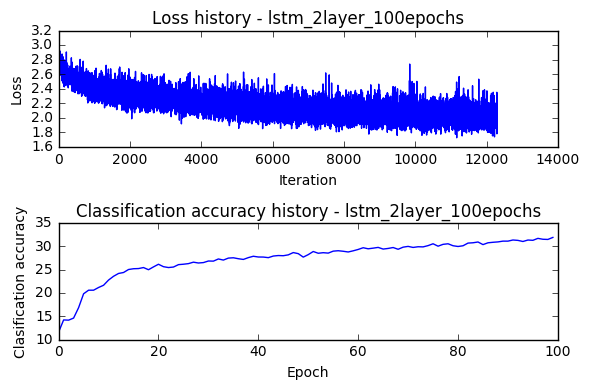

In [16]:
title = "lstm_{}layer_{}epochs".format(num_layers, num_epochs)
results_file = title + "_" + time.strftime("%Y%m%d_%H_%M.jpg")
Utils.visualize_stats(history.stats, results_dir + results_file, title)